<a href="https://colab.research.google.com/github/mikeusru/scikit-learn-training/blob/main/ensemble_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ensemble Learning
What's bad? A badly chosen ML algorithm. What's better? A well-chosen ML algorithm. What's even better? A whole bunch of algorithms working together to get an optimal result from a bunch of different predictions.

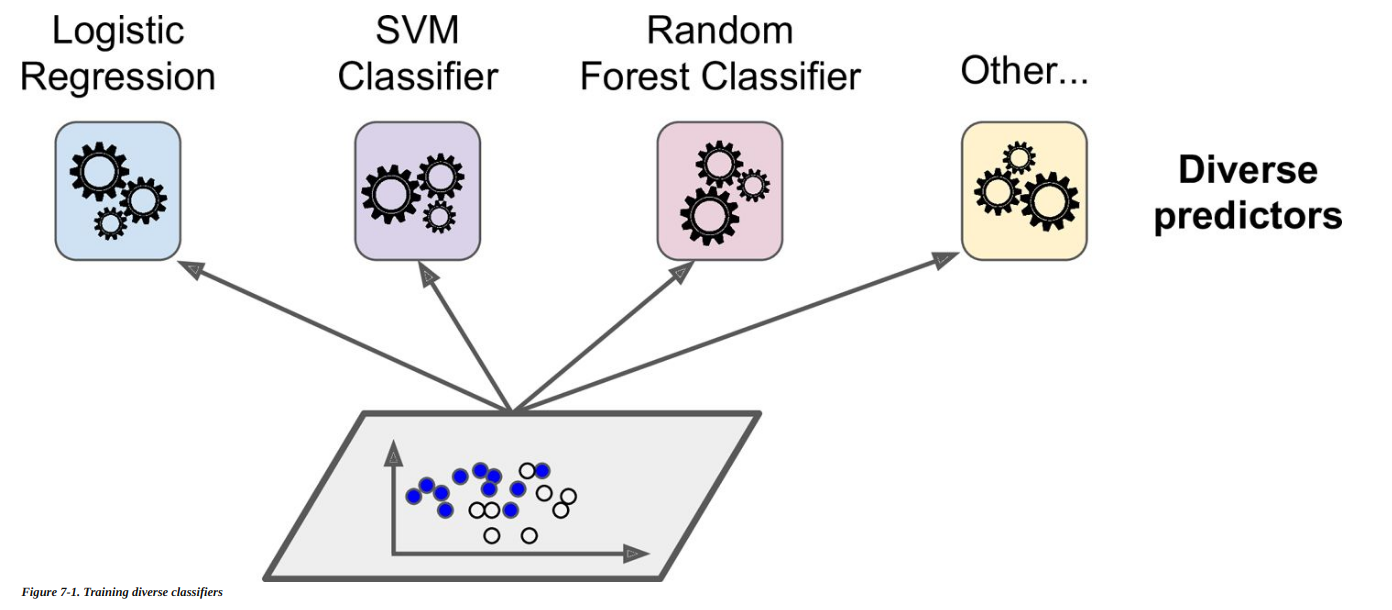

An important thing to note is that when you have a bunch of models performing to get a result, it's important that they aren't making the same mistake. Averaging out a bunch of independent predictions is more likely to get you a correct prediction, but if a lot of the models are making the **same exact mistakes**, you're going to end up with a worse result for it.

## Loading the data

We're going to use the moons dataset for this one.

In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

X, y = make_moons(n_samples=200, noise=0.25)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = RANDOM_SEED)

## Voting Classifier
To create a result from our ensemble of models, we're going to use a voting classifier. A majority vote classifier is a *hard* vote classifier.

In [2]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
      estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
      voting='hard'
)

In [3]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                             

Now, we can check the accuracy each of our models, as well as the voting classifier ensemble, on the test set.

In [4]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.7
RandomForestClassifier 0.92
SVC 0.8
VotingClassifier 0.8


There you have it! Depending on some randomness, perhaps the voting classifier even bested the results of the individual models, althought this is certainly not always the case.

We can also change the model from "hard" to "soft" voting, where the model predicts the average probability averaged over all the individual classifiers. It gives more weights to highly confident votes, thus often achieves better results than hard voting. We need to have our models to have a predict_proba method for this, which requires us to set the SVC hyperparameter to True.

In [5]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC(probability=True)

voting_clf = VotingClassifier(
      estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
      voting='soft'
)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.7
RandomForestClassifier 0.92
SVC 0.8
VotingClassifier 0.84


I love when results don't back up my statements. In my case, the classifier is less accurate here, but hey, I never said it ALWAYS works.

##Bagging and Pasting
To improve the chances that models in an ensemble aren't making the same mistakes, we can train them on varying samples takes from the training data. **Bagging** stands for *bootstrap aggregation*, and refers to data being sampled with replacement, while **pasting** means sampling without replacement. Thus, in bagging, training sets for different models can share training data.

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)


In [7]:
from matplotlib import pyplot as plt
from mlxtend.plotting import plot_decision_regions

def plot_classifier_graph(X, y, clf):
  plt.figure(figsize=(10,10))
  plot_decision_regions(X, y, clf=clf, legend=2)
  plt.legend()
  plt.tight_layout()

Let's take a look at a decision tree classifier as opposed to a bagging classifier with 500 estimators.

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


Text(0.5, 1.0, 'Decision Tree Classifier')

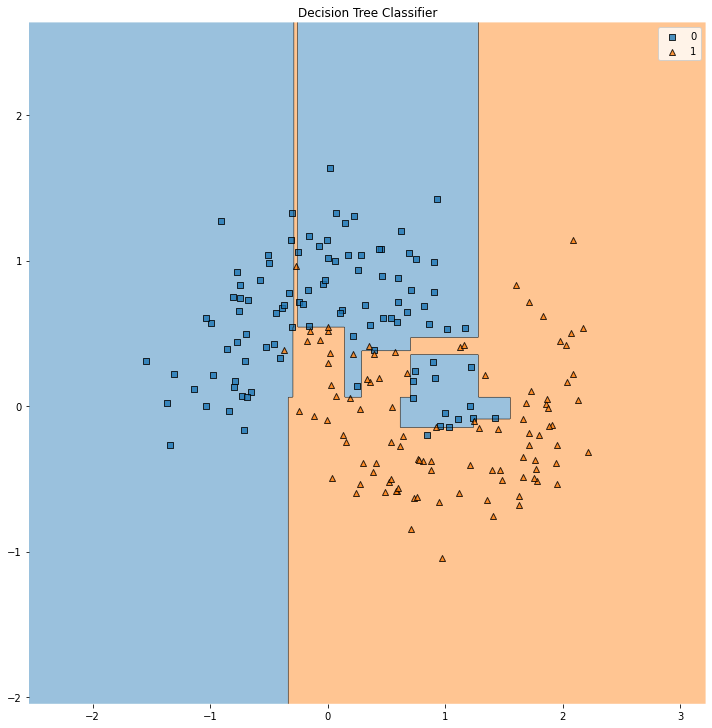

In [8]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)


plot_classifier_graph(X, y, tree_clf)
plt.title("Decision Tree Classifier")

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


Text(0.5, 1.0, 'Decision Tree Bagging, n=500')

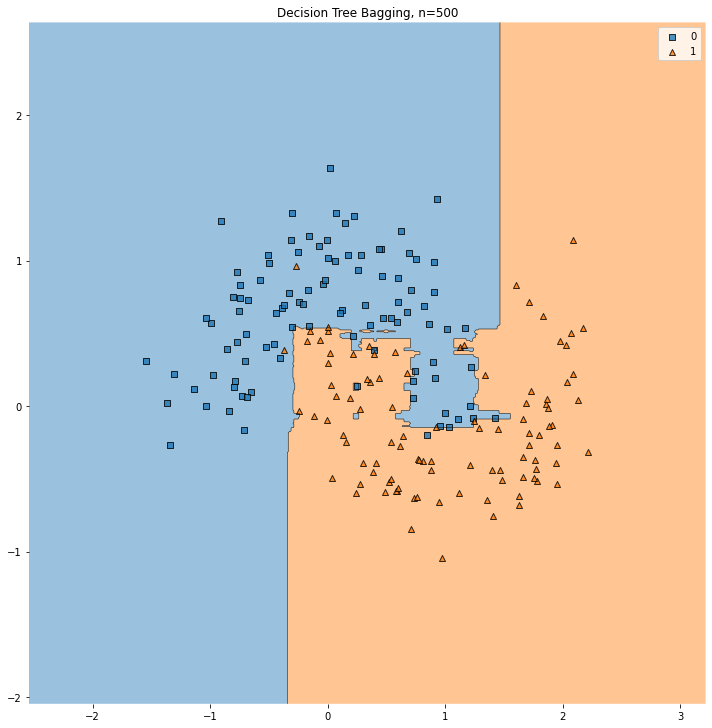

In [9]:
plot_classifier_graph(X, y, bag_clf)
plt.title("Decision Tree Bagging, n=500")

There's some weird stuff around the edges of the dividing lines, but we can certainly see that a bagging classifier, where we used 500 decision trees and did a soft voting classifier on the results, will generalize *much* better than a single decision tree.

## Out-of-bag evaluation
To evaluate a bagging classifier, scikit-learn can use what's referred to as out-of-bag instances, or the instances which aren't included in the bag of each individual model it builds. Setting *oob_score* to True will then calculate an evaluation score, stored in the oob_score_ variable.

In [10]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8933333333333333

This is a calculation from scores within the training set which the individual models *weren't* trained on. let's see if it generalizes to the test set.

In [11]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.96

## Random Forests
Probably the best-known ensemble model, a random forest is a collection of decision trees, similar to the one we created earlier. A random forest classifier is more convenient and optimized for decision trees than a bagging classifier, hence, it's a thing. n_jobs, by the way, refers to the amount of tasks we can run in parallel. None or 1 means no parallel tasks, while -1 indicates we should use all the CPU cores we can find.

In [12]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.96

## Extremely Randomized Trees
A random forest classifier where the thresholds for the splits are random (as opposed to searching for the best possible thresholds for each split) is called *extremely randomized trees*. Good to know about. Referred to as ExtraTreesClassifier, it doesn't have extra trees - they're just super random.

In [13]:
from sklearn.ensemble import ExtraTreesClassifier
ert_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
ert_clf.fit(X_train, y_train)

y_pred_rf = ert_clf.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.82

## Measuring feature importance
Random forests, like decision trees, are good at helping us understand the relative importance of individual features in the data.

In [14]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
  print(f"{name} importance score: {score}")

sepal length (cm) importance score: 0.09410748571311187
sepal width (cm) importance score: 0.01998732358330976
petal length (cm) importance score: 0.44739547811415187
petal width (cm) importance score: 0.43850971258942656


This is a handy way of figuring out which features you need to keep, and which you can either get rid of or somehow engineer to make more useful.

## Boosting
The beautiful method of taking a bunch of weak learners and making a powerful one is called Boosting, and is the backbone of some popular algorithms. 

In the algorithm **AdaBoost**, short for *adaptive boosting*, a predictor will pay more attention to the training instances that the previous predictor missed. This, each predictor in the lineup increases its focus on the hard cases. Naturally, since every step relies on the previous one. AdaBoost can't be parallelized. 

In [15]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), 
    n_estimators=200,
    algorithm="SAMME.R",
    learning_rate=0.5)
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

**Gradient Boosting** is similar to AdaBoost, but instead of tweaking instance weights for every iteration, it tries to fit the new predictor to the residual errors made by the previous predictor.

In [85]:
from sklearn.datasets import load_boston
from sklearn.tree import DecisionTreeRegressor
import pandas as pd

boston_data = load_boston()
data = pd.DataFrame(data=boston_data["data"], columns=boston_data["feature_names"])
X = data["LSTAT"].values.reshape((-1,1))
y = boston_data["target"]

tree_reg1 = DecisionTreeRegressor(max_depth=3)
tree_reg1.fit(X, y)

# Next, train another regressor on the residual errors from the first regressor

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=3)
tree_reg2.fit(X, y2)

# and again

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=3)
tree_reg3.fit(X, y3)


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Confusing? We're subtracting the incorrect correct predictions from the correct ones, so correct predictions should be zero. Each new model just needs to predict zero for the correct classes, and whatever the residual error is for the previously incorrectly predicted classes. Let's plot the results (with just one of X's features) to better understand them.  

In [86]:
import numpy as np
from matplotlib import pyplot as plt
def plot_regression_model(X, y, regressor):
  X, y, plt.scatter(X, y, color='red')
  X_grid = np.arange(min(X), max(X), 0.01)
  X_grid = X_grid.reshape((len(X_grid), 1))
  plt.plot(X_grid, regressor.predict(X_grid), color='blue')

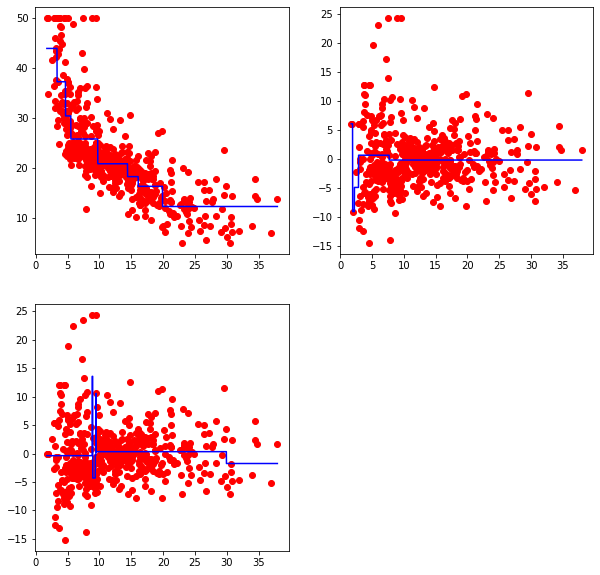

In [89]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plot_regression_model(X, y, tree_reg1)
plt.subplot(2,2,2)
plot_regression_model(X, y2, tree_reg2)
plt.subplot(2,2,3)
plot_regression_model(X, y3, tree_reg3)


Our first tree simplified the data quite a bit, but we can see that the residual errors here are likely too difficult to predict given the noise. Of course we're choosing just one feature from the dataset for visualization here, and a bunch of features would likely perform better as predictors. 

Naturally, gradient boosting has its own algorithm in scikit-learn so we don't have to do this stepwise subtraction.

In [90]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=3, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Note that we added a learning_rata parameter - in this case, it scales the contribution from each tree. A low value such as 0.1 means more trees are needed to fit the training set, but generalization will work better. This regularization technique is called *shrinkage*, referring to the diminishing contribution of the models. 

## Optimizing the amount of trees

In order to get an estimate for how many trees the model should train on, we can plot the validation error based on tree number. For this case, we'll be using the whole boston dataset, and the staged_predict method to get validation errors for each added tree. 

Lowest validation error at 241 estimators


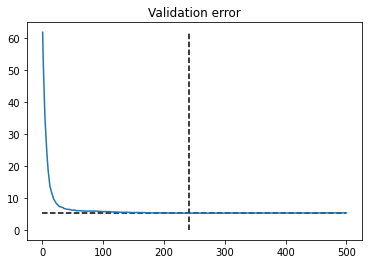

In [132]:
from sklearn.metrics import mean_squared_error

boston_data = load_boston()
X, y = boston_data['data'], boston_data['target']
X_train, X_val, y_train, y_val = train_test_split(X, y)

max_estimators = 500

gbrt = GradientBoostingRegressor(max_depth=3, n_estimators=max_estimators)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
best_n_estimators = np.argmin(errors) + 1

plt.plot(np.linspace(1,max_estimators,max_estimators), errors)
plt.vlines(best_n_estimators, 0, np.max(errors), linestyle='dashed')
plt.hlines(np.min(errors), 0, max_estimators, linestyle='dashed')
plt.title('Validation error')
print(f"Lowest validation error at {best_n_estimators} estimators")


## XGBoost and early stopping
Gradient boosting is cool, and there's a whole deparate library for it called XGBoost - *Extreme* gradient boosting. It's more optimized, and allows you to stop training once the lowest validation point has been reached.


In [135]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=5)
y_pred = xgb_reg.predict(X_val)

[15:34:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:20.7282
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:18.814
[2]	validation_0-rmse:17.0903
[3]	validation_0-rmse:15.5227
[4]	validation_0-rmse:14.1234
[5]	validation_0-rmse:12.838
[6]	validation_0-rmse:11.6798
[7]	validation_0-rmse:10.6732
[8]	validation_0-rmse:9.75851
[9]	validation_0-rmse:8.92599
[10]	validation_0-rmse:8.21407
[11]	validation_0-rmse:7.5512
[12]	validation_0-rmse:6.9562
[13]	validation_0-rmse:6.43416
[14]	validation_0-rmse:5.96392
[15]	validation_0-rmse:5.55089
[16]	validation_0-rmse:5.18975
[17]	validation_0-rmse:4.87159
[18]	validation_0-rmse:4.62176
[19]	validation_0-rmse:4.34974
[20]	validation_0-rmse:4.13106
[21]	validation_0-rmse:3.93513
[22]	validation_0-rmse:3.75364
[23]	validation_0-rmse:3.60705
[24]	validation_0-rmse:3.46486
[25]	validation_0-rmse:3.34068
[26]	validation_0

## Stacking
Extreme! Now let's look at stacking. Instead of using hard or soft voting to aggregate the predictions, stacking trains a model to aggregate the solution. This final model is called the *blender* or *meta-learner*.
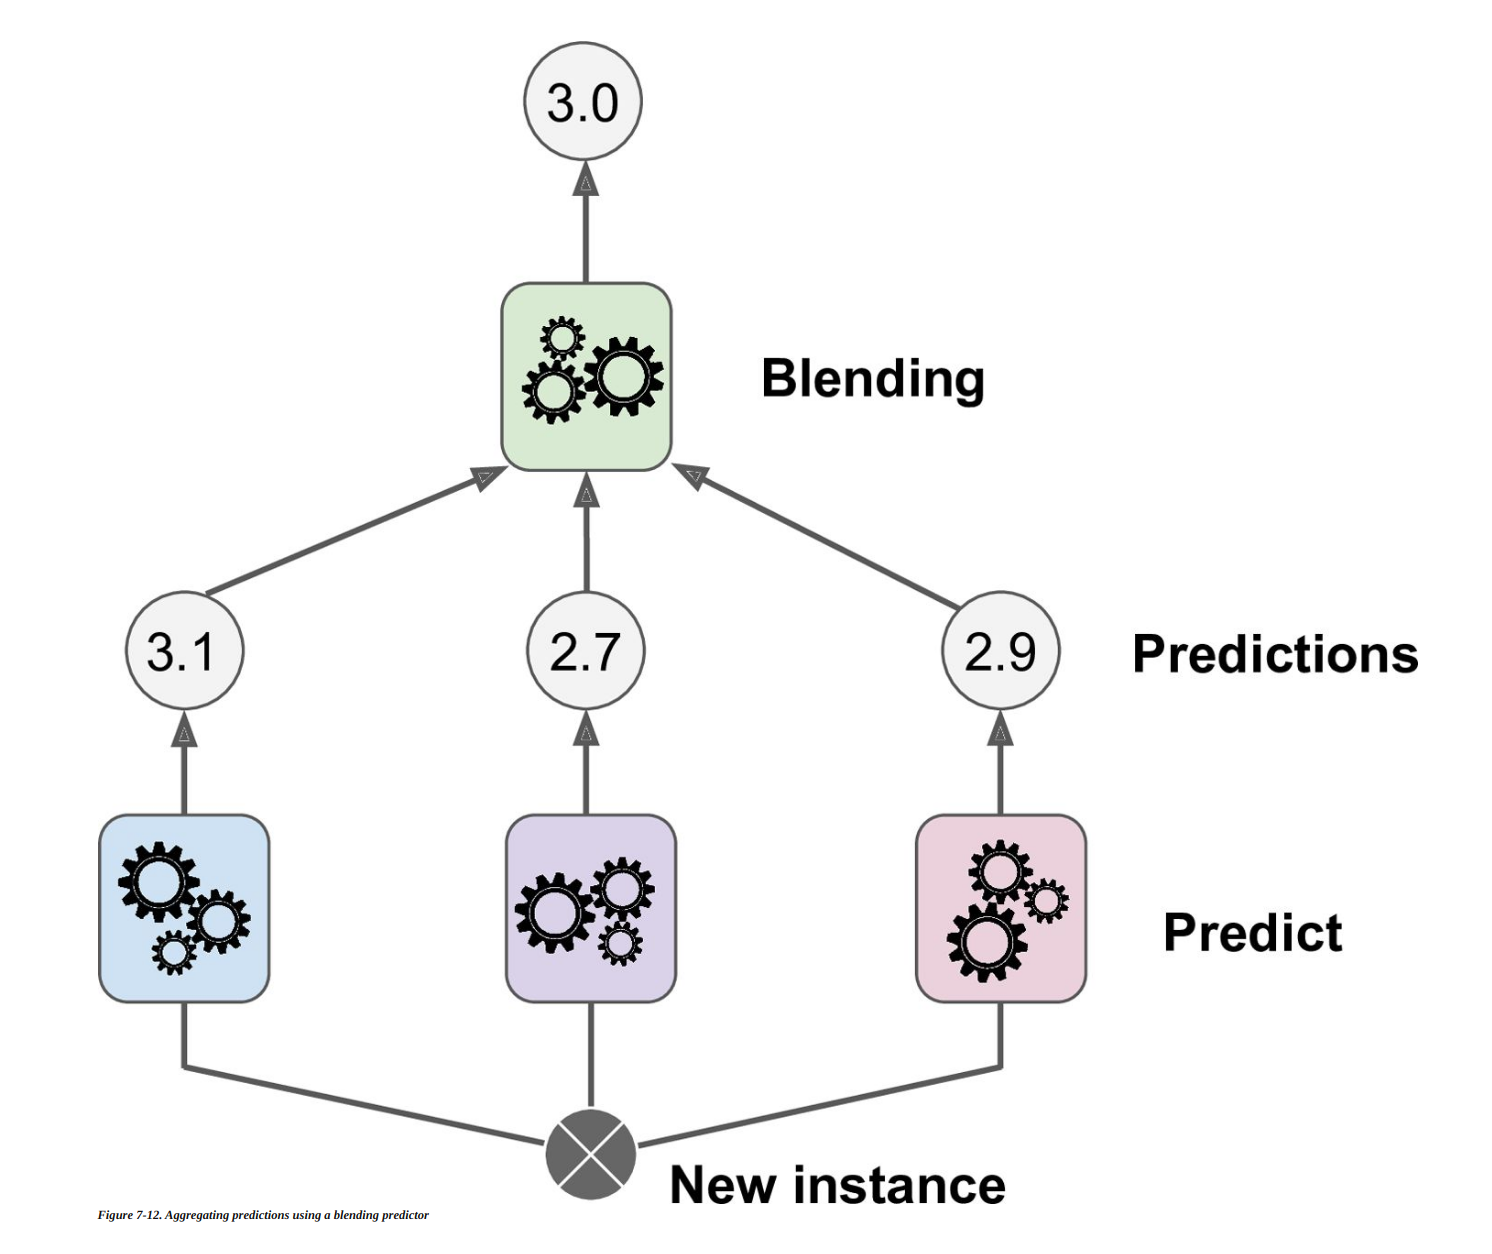

To make stacking work, we need to split out another piece of data called the *hold-out set*. The ensemble predictors are trained on the normal dataset, while the blender is trained on the data resulting from running the hold-out set through the predictors. In the following case, we'll train a stacking classifier which uses a logistic regression as the blender.

In [142]:
from sklearn.ensemble import StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X, y = load_iris(return_X_y=True)
estimators = [
              ('rf', RandomForestClassifier(n_estimators=10, random_state=RANDOM_SEED)),
              ('svr', make_pipeline(StandardScaler(),
                                    LinearSVC(random_state=RANDOM_SEED)))
]
stk_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=RANDOM_SEED)
stk_clf.fit(X_train, y_train).score(X_test, y_test)


0.9473684210526315